In [22]:
%pylab inline
import numpy as np
import torch
import tensorflow as tf

from torch import nn 
from torch.autograd import Variable

from PIL import Image
from scipy import signal as sg

Populating the interactive namespace from numpy and matplotlib


In [2]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.01, allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

# Convolution Neural Network 

## Convolution

Convolution은 2개의 함수들 (e.g. $ f $ * $ g $ 처럼 * asterisk를 사용)에 적용되는 일종의 덧셈 뺄셈과 같은 operations이며, 새로운 함수인 $ h $를 생성을 합니다. <br>
새로운 함수 $ h $는 함수 $ f $가 다른 함수 $ g $위를 지나가면서 중첩된 부분을 element-wise multiplication으로 연산뒤 각 구간별 integral을 나타냅니다.

$$ (f * g)(t) = \int^\infty_{-\infty} g(\mathcal{T}) f(t-\mathcal{T}) \ d\mathcal{T} $$

* $ f $ 또는 $ g $ 는 convolution에서는 함수를 가르키지만 convolution neural network에서는 이미지를 가르킴
* $ t $ signal에서는 시간을 가르키지만, 이미지 프로세싱에서는 위치를 가르킴


convolution을 실제 구현하는 공식은 주로 cross correlation을 사용합니다. (flip이 되는점이 차이가 있음)<br>
$ G = H * F $ 는 convolution일때 다음과 같습니다. <br>
( $ F $는 kernel/filter 그리고 $ H $ 는 input)

**Convolution 연산**

$$ H[i, j] = \sum^k_{u=-k} \sum^k_{v=-k} F[u, v] I[i -u, j-v] $$

**Cross Correlation 연산**

$$ H[i, j] = \sum^k_{u=-k} \sum^k_{v=-k} F[u, v] I[i+u, j+v] $$


예를들면 다음과 같습니다.

<img src="images/convolution_example.png">

$ H[3, 2] $ 일때의 연산이며, 왼쪽테이블은 Image의 위치, 중간은 이미지 값, 오른쪽은 filter/kernel값입니다.<br>
예제에서 k의 값은 1을 갖습니다. 따라서 이미지를 읽어드리는 순서는 60 -> 70 -> 80 -> 110 -> 120 -> 130 -> 160 -> 170 -> 180의 순서가 됩니다.<br>
convolution의 경우 flip이 되어서 반대 순서로 나가게 됩니다.

## Convolution을 직관적으로 이해하기

직관적으로 convolution을 이해하기 위한 코드는 아래와 같습니다.  <br>
아래의 예제에서는 이미지의 한 부분이 서로 비슷한 색상을 갖고 있으면 서로 상쇄를 시켜줘서 0값이 되지만, sharp-edge부분을 만나게 되면 색상차이가 커져서 해당 부분의 convolution값이 높아지게 됩니다. 아래에서 차의 윤곽 부분의 값이 높아진것을 알 수 있습니다. <br>
그 외에도 blur, sharpen등등 이미지를 변환시킬수 있습니다.

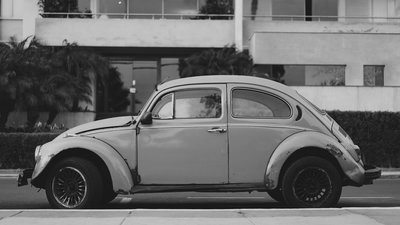

[원본 이미지] pic size: (225, 400)



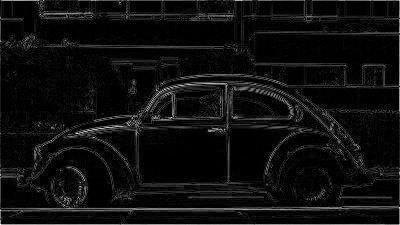

[Edge Detection] pic size:(225, 400)



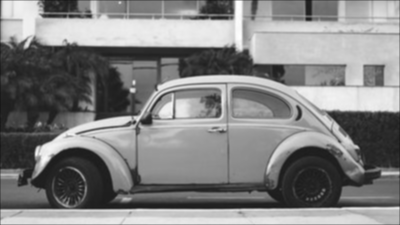

[Blur] pic size:(225, 400)



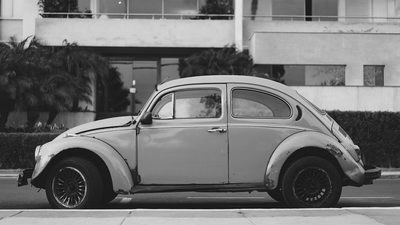

[Sharpen] pic size:(225, 400)



In [3]:
def norm(ar):
    return np.uint8(255*np.absolute(ar)/np.max(ar))

def scipy_convolve(pic, f, mode, title=None):
    h = sg.convolve2d(pic, f, mode='same')
    filtered_pic = Image.fromarray(norm(h))
    display(filtered_pic)
    print(f'[{title}] pic size:{h.shape}')
    print()

pic = Image.open('./images/car.jpg').convert('L')
display(pic)
pic = np.array(pic)
print('[원본 이미지] pic size:', pic.shape)
print()

f_edge = np.array([[-1, -1, -1],
              [-1,  8, -1],
              [-1, -1, -1]])

f_blur = np.array([[1, 2, 1],
                   [2, 4, 2],
                   [1, 2, 1]])

f_sharpen =  np.array([[0, -2, 0],
                       [-2, 255, -2],
                       [0, -2, 0]])

scipy_convolve(pic, f_edge, mode='same', title='Edge Detection')
scipy_convolve(pic, f_blur, mode='same', title='Blur')
scipy_convolve(pic, f_sharpen, mode='same', title='Sharpen')

## 1D Convolution Operation

1D convolution은 signal processing에서 사용됩니다.

$$ (f * g)(t) = \sum^M_{i=1} g(i) \cdot f(t - i + M/2)  $$

* $ f $는  input vector 이고, $ g $는 kernel입니다.
* $ f $는 $ N $ length를 갖었고, $ g $는 $M$ length를 갖고 있습니다.
* $ M/2 $ 에서 round 처리합니다.
* kernel을 input vector위로 지나가게 하면서 연산을 합니다.

예를 들어서 다음과 같은 1D input vector와 kernel을 갖고 있습니다.

$$ \begin{align}
f &= [10,\ 50,\ 60,\ 10,\ 20,\ 40,\ 30] \\
g &= \left[\frac{1}{3}, \frac{1}{3}, \frac{1}{3} \right]
\end{align}$$

$ h(3) $의 값을 연산하고자 하면 다음과 같습니다.

$$ 50 \cdot \frac{1}{3} + 60 \cdot \frac{1}{3} + 10 \cdot \frac{1}{3} = 40 $$

궁극적으로 1D convolution을 연산하면 다음과 같은 결과값을 기대할 수 있습니다.

$$ h = [20,\ 40,\ 40,\ 30,\ 23.33,\ 30,\ 23.33] $$

### [Scipy]

In [4]:
g = np.array([10, 50, 60, 10, 20, 40, 30], dtype='float64')
f = np.array([1/3., 1/3., 1/3.], dtype='float64')

_r = sg.convolve(g, f, mode='same')
print(_r.astype('float16'))

[20.   40.   40.   30.   23.33 30.   23.33]


### [TensorFlow]

1D convolution은 signal에서 사용합니다.<br>
Input shape은 데이터 형식이 **"NHWC"**라면  <span style="color:red">$ (N, W_{in}, C_{in}) $</span> 또는 **"NCHW"**라면 <span style="color:red">$ (N, C_{in}, W_{in}) $</span>이어야 합니다.<br>
filter/kernel shape은 <span style="color:red">$ (W_{filter}, C_{in}, C_{out}) $</span> 이어야 합니다.


In [5]:
_g = g.reshape(-1, 7, 1)
_f = f.reshape(3, 1, 1)

g_tf = tf.placeholder('float32', shape=(None, 7, 1), name='g')
f_tf = tf.placeholder('float32', shape=(3, 1, 1), name='f')

conv_op = tf.nn.conv1d(g_tf, f_tf, stride=1, padding='SAME', data_format='NHWC')
conv_op = tf.reshape(conv_op, (1, 7))
_r = sess.run(conv_op, feed_dict={g_tf:_g, f_tf:_f})
print(_r.astype('float16'))

[[20.   40.   40.   30.   23.33 30.   23.33]]


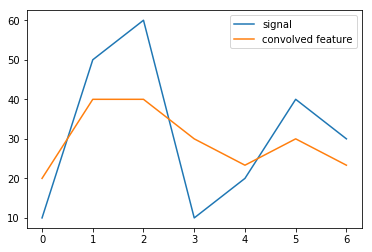

In [6]:
plot(g, label='signal')
plot(_r.reshape(-1), label='convolved feature')
legend()

## 2D Convolution Operation

2D Convolution은 CNN에서 일반적으로 사용하는 방법입니다. <br>
실제 convolution을 연산하는 방법의 종류는 다양하게 있으나 TensorFlow에서는 cross correlation을 사용합니다. <br>


#### Convolution VS Cross Correlation

Convolution과 cross correlation은 서로 동일하게 element-wise multiplication을 합니다.<br>
다만 convolution은 kernel(filter)가 되는 matrix을 거꾸로 한번 뒤집어 준다음에 연산을 하고,<br>
Cross correlation은 뒤집는 것없이 바로 element-wise multiplication을 한 후 합을 구합니다.

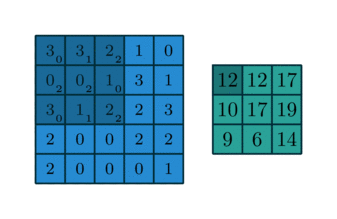

In [25]:
from IPython.display import Image as ImageDisplay
ImageDisplay("images/numerical_no_padding_no_strides.gif")

### [Scipy]

`sg.convolve2d` 를 사용하면 결과가 다릅니다. 이는 kernel을 연산전 한 번 뒤집어서 사용하기 때문입니다.

In [32]:
image = np.array([[3, 3, 2, 1, 0], 
                  [0, 0, 1, 3, 1], 
                  [3, 1, 2, 2, 3],
                  [2, 0, 0, 2, 2],
                  [2, 0, 0, 0, 1]])
kernel = np.array([[0, 1, 2], 
                   [2, 2, 0], 
                   [0, 1, 2]])
h = sg.convolve2d(image, kernel, mode='valid')
print(h)

[[18 20 19]
 [10  9 17]
 [11  8 14]]


In [33]:
h = sg.correlate2d(image, kernel, mode='valid')  # Cross Correlate
print(h)

[[12 12 17]
 [10 17 19]
 [ 9  6 14]]


### [TensorFlow]

Input Tensor shape은 <span style="color:red">$ (N, H_{in}, W_{in}, C_{in}) $ </span>와 같아야 합니다.<br>
Filter 또는 kernel의 shape은 <span style="color:red">$( H_{filter}, W_{filter}, C_{in}, C_{out}) $</span> 와 같아야 합니다.

* $ N $: Batch Size
* $ H $: Height
* $ W $: Width
* $ C $: Channel (Color)


In [34]:
_g = image.reshape(-1, 5, 5, 1)
_f = kernel.reshape(3, 3, 1, 1)
g_tf = tf.placeholder('float32', shape=(None, None, 5, 1), name='g')
f_tf = tf.placeholder('float32', shape=(3, 3, 1, 1), name='f')

conv_op = tf.nn.conv2d(g_tf, f_tf, strides=(1, 1, 1, 1), padding='VALID')
conv_op = tf.reshape(conv_op, (3, 3))

print(sess.run(conv_op, feed_dict={g_tf:_g, f_tf:_f}))

[[12. 12. 17.]
 [10. 17. 19.]
 [ 9.  6. 14.]]


### [Pytorch]

torch.nn.Conv2d의 경우 Input size는 <span style="color:red">**$ (N, C_{in}, H, W) $**</span>이어야 하며, <br>
output은 <span style="color:red">**$ (N, C_{out}, H_{out}, W_{out}) $**</span> 이며, 다음과 같은 공식을 갖습니다.

$$ \begin{array}{ll}
out(N_i, C_{out_j})  = bias(C_{out_j})
               + \sum_{{k}=0}^{C_{in}-1} weight(C_{out_j}, k)  \star input(N_i, k)
\end{array}$$

In [35]:
def create_conv(kernel, bias=None, in_channels=1, out_channels=1):
    kernel_size = kernel.shape[-1]
    kernel_ts = torch.FloatTensor(kernel)
    if bias:
        bias_ts = torch.FloatTensor(bias)
    else:
        bias_ts = torch.FloatTensor(np.zeros([1]))
    
    conv_f = torch.nn.Conv2d(1, 1, kernel_size, stride=1)
    conv_f.register_parameter('weight', torch.nn.Parameter(kernel_ts))
    conv_f.register_parameter('bias', torch.nn.Parameter(bias_ts))
    return conv_f

_g = image.reshape(-1, 1, 5, 5)
_f = kernel.reshape(-1, 1, 3, 3)
g_tensor = Variable(torch.FloatTensor(_g))

conv = create_conv(_f)
print(conv(g_tensor).data.numpy()[0][0])

[[12. 12. 17.]
 [10. 17. 19.]
 [ 9.  6. 14.]]


## Convolved Feature

filter/kernel의 갯수, 크기, padding, stride의 값등에 따라서 convolution으로 연산된 convolved feature(output)의 형태가 달라질수 있습니다. <br>
일반적으로 필터의 갯수가 많아질수록, 이미지에서 뽑아내는 features들의 갯수가 늘어가게 되며, 좀 더 복잡한 문제를 해결하는 네트워크를 만들수 있습니다. 

convolved feature (convolution연산을 통해 나온 output)는 다음의 parameters들에 의해서 결정될 수 있습니다. 

* **Depth**: filter의 갯수를 가르킵니다. 
* **Stride**: convolution연산시 input이미지위를 filter가 지나가면서 연산을 하게 되는데, 이때 이동하는 pixel의 갯수를 의미합니다.
* **Zero-Padding**: zero-padding을 추가함으로서 convolution연산후 크기가 줄어들지 않도록 합니다. zero-padding을 사용하는 convolution을 wide convolution이라고 하며, 사용하지 않는것은 narrow convolution이라고 합니다.

## Pooling Step

Subsampling 또는 Downsampling이라고도 하며, 가장 중요한 정보는 남기되 dimensionality를 줄일수 있는 방법입니다. <br>
Max, Average, Sum등이 사용 될 수 있습니다. 

<img src="images/maxpool.jpeg">

위의 예에서는 2x2 filter 싸이즈, stride는 2값으로 max pooling을 했을때의 결과입니다.

### [TensorFlow]

tf.nn.max_pool(value, ksize, strides, padding, data_format='NHWC', name=None)를 사용할수 있습니다.

* **value:** $ (N, H, W, C)$ 형태를 갖은 input tensor
* **ksize:** filter의 크기
* **strides:** 각각의 input dimension마다 얼마만큼씩 slide할지를 결정
* **padding:** 'VALID' 또는 'SAME' 사용
* **data_format:** 'NHWC' 또는 'NCHW' 사용

In [11]:
pic = np.array([[1, 1, 2, 4], 
                [5, 6, 7, 8], 
                [3, 2, 1, 0], 
                [1, 2, 3, 4]])
pic = pic.reshape(1, 1, 4, 4)

pic_tf = tf.placeholder('float32', shape=(None, 1, 4, 4), name='pic')

pool_op = tf.nn.max_pool(pic_tf, ksize=(1, 1, 2, 2), strides=(1, 1, 2, 2), padding='SAME', data_format='NCHW')
pool_op = tf.reshape(pool_op, (2, 2))
output = sess.run(pool_op, feed_dict={pic_tf: pic})
print(output)

[[6. 8.]
 [3. 4.]]


# References


**Convolution**

* [코넬대학교 CS1114 Section 6: Convolution](http://www.cs.cornell.edu/courses/cs1114/2013sp/sections/S06_convolution.pdf)
* [카네기멜론 Convolution and Edge Detection](http://graphics.cs.cmu.edu/courses/15-463/2005_fall/www/Lectures/convolution.pdf)
* [카네기멜론 On the Origin of Deep Learning](https://arxiv.org/pdf/1702.07800.pdf)
* [The Convolution Operation and CNNs](http://www.cedar.buffalo.edu/~srihari/CSE676/ConvolutionFunction.pdf)
* [유타 Spatial Filtering](http://www.coe.utah.edu/~cs4640/slides/Lecture5.pdf)
* [The Convolution Operation and CNNs](http://www.cedar.buffalo.edu/~srihari/CSE676/ConvolutionFunction.pdf)
* [Introduction to Differential Equations](https://www.math.ust.hk/~machas/differential-equations.pdf)
* [메릴랜드 대학 Correlation and Convolution](http://www.cs.umd.edu/~djacobs/CMSC426/Convolution.pdf)

**Convolution Neural Network**

* [Understanding Convolutional Neural Networks](http://davidstutz.de/wordpress/wp-content/uploads/2014/07/seminar.pdf)
* [An Intuitive Explanation of Convolutional Neural Networks](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)